# MNIST Classification
In this notebook, I'll be going through a very simple classification problem and documenting each step. The goal is to create an example notebook for future classification problems.

## Get the Data
Downloading MNIST using scikit-learn:

In [2]:
from sklearn.datasets import fetch_openml
# set as_frame to False for numpy
mnist = fetch_openml('mnist_784', version=1, as_frame=False, data_home='./datasets')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# Dataset Description
# mnist["DESCR"]

Creating variables for data and labels:

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

There are 70,000 images, each with 784 features. In this case, the features are individual pixels of each image, since each image is 28 x 28 pixels. 

Let's take a look at a random image:

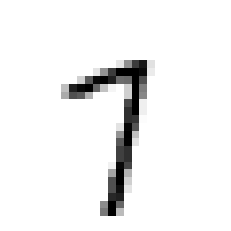

In [7]:
# Display a digit from array
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[42]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [8]:
y[42]

'7'

Note that the label is a string, let's convert it to an int so that our algorithm will understand:

In [9]:
import numpy as np
y = y.astype(np.uint8)

In [10]:
y[42]

7

## Create test set and train set
We should always split the data into training and testing BEFORE looking into the data. The MNIST dataset is already split (first 60,000 is training, last 10,000 is test) and shuffled, so we just need to index it:

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
Let's simplify the problem by first training a simple binary classifier that will identify one digit, let's choose 7. It will pick between two classes: 7 and not-7.

In [12]:
y_train_7 = (y_train == 7)
y_test_7 = (y_test == 7)

Now our labels will be boolean values, based on whether the given digit is a seven or not.

In [13]:
y_train_7[:9]

array([False, False, False, False, False, False, False, False, False])

As you can see, most values will be False, which is expected.

Let's start with training an SGD classifier:

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_7)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

We can see for this digit that we displayed before, the binary classifier correctly predicted that it was a 7. That's great, but we should develop a better way to evaluate this model and any future classifiers we use.

## Performance Measures
Evaluating a classifier is a bit trickier than a regressor, we're going to try a few different methods here.

### Cross-Validation
Let's use K-fold cross-validation to evaluate our model. For *n* number of folds, it will evaluate our model *n* times, each time training the model on *n-1* folds and testing it on the remaining one.

Let's use scikit-learn's `cross_val_score()` to keep it simple:

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_7, cv=3, scoring="accuracy")

array([0.98105, 0.9735 , 0.95335])

Wow, so it appears that our model has an accuracy above 95%! Before we get too excited, let's compare it to another classifier here that will always guess that the digit is **not** seven:

In [17]:
from sklearn.base import BaseEstimator

class NeverSevenClassifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Let's see how it performs:

In [18]:
never_seven_classifier = NeverSevenClassifier()
cross_val_score(never_seven_classifier, X_train, y_train_7, cv=3, scoring="accuracy")

array([0.89535, 0.8984 , 0.893  ])

Almost 90%! Thinking about it, this is totally expected. There are 10 possible digits, so guessing that a given digit will be 7 has 10% odds. 

Thus, accuracy is generally not the preferred perfomance measure for classifiers, especially for *skewed datasets* (in this case, not-7 is way more likely than 7).

## Confusion Matrix